<a href="https://colab.research.google.com/github/Jun-Liu-291/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/master/1_California_housing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tarfile
import urllib.request

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path,"housing.csv")
  return pd.read_csv(csv_path)

# Take a quick look at the data structure

In [5]:
housing = load_housing_data()
housing.head() # look a top five rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# info() get quick description of the data
# inparticular the total number of rows, each attribute's type, and number of nonnull values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Note total bedrooms has 20433 non-null data, which means that 207 districts are missing this feature.

In [7]:
# value_counts() return the number for different values
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
# describe() shows a summary of the numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


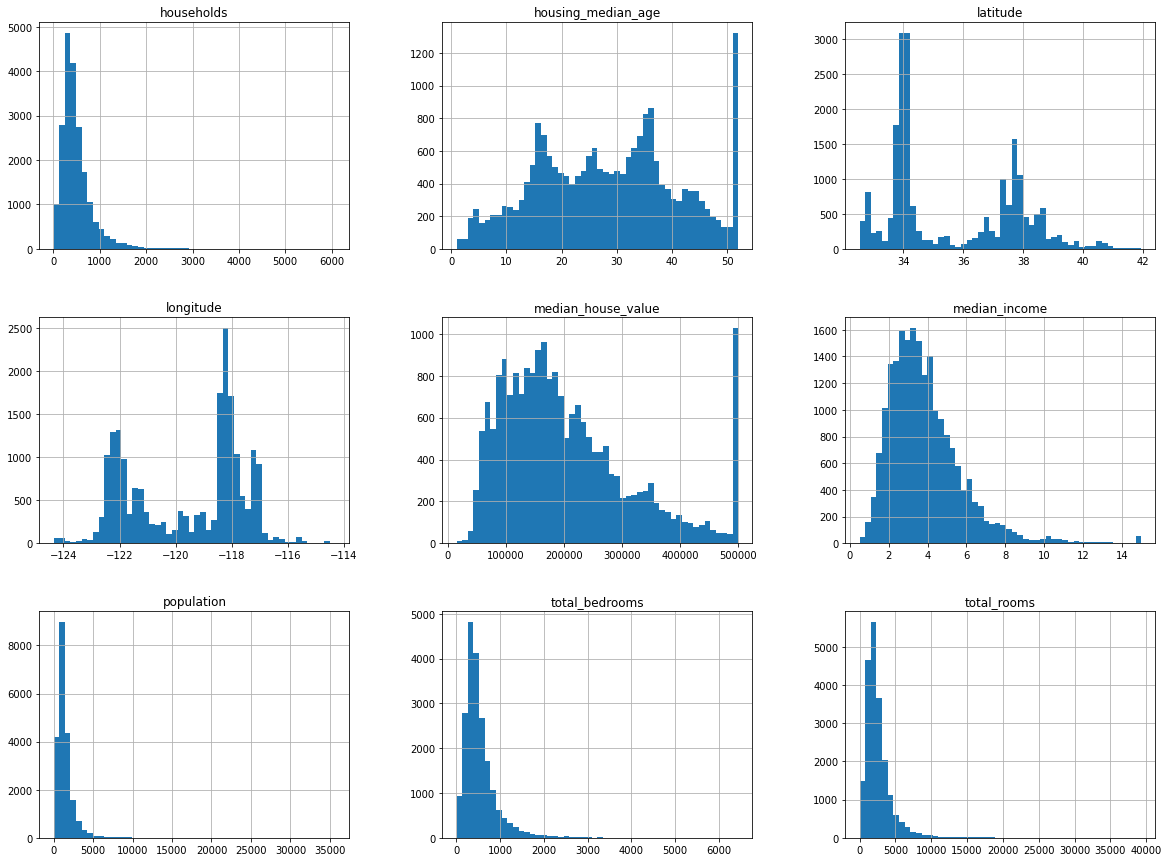

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

1. median income attributes has been scaled and capped at 15 for higher incomes and at 0.5 for lower median incomes. and should times 10000 than we can get the actual median incomes(eg. 4 actually means about $40,000)

2. housing median age and the medain house value were also capped. In this case, median house value is our label, in the training set we will never get predictions beyond $500,000, than we have two options.<br>

  a. collect proper labels for the districts whose labels were capped.<br>
  b. remove those districts from the training set(and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).<br>

3. these attributes have very different scales.

4. many histograms are tail-heavy.

# Create a Test Set

Why? Since when we check the data, we might find some intereting pattern, which will make us choose a special algorithms. In this case, when we estimate the generalization erro using the test set, our estimate will not be too optimistic, and we will lauch a system that will not perform as well as expected. This is called*** data snooping bias***

## shuffle the data and split by ratio

In [10]:
import numpy as np

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices= shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)

print("The length of train set is ", len(train_set))
print("The length of test set is  ", len(test_set))

The length of train set is  16512
The length of test set is   4128


This works but not perfect, since when we run the program again, it will generate a different test set.

one solution for this problem is th se random seed with *np.random.seed(42)* before calling *np.random.permutation()*.

But this will generate a new problem, which is when we have an updated dataset.

## split test set with Cyclic Redundancy Check

compute the has of each instance's identifier, if the hash is lower than or equal to 20%, then put it into test set

In [12]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

print("The length of train set is ", len(train_set))
print("The length of test set is  ", len(test_set))

The length of train set is  16512
The length of test set is   4128


another thing we need to make sure, is that new data gets appended to the end of the dataset and that no row ever gets deleted.

If it is not possible, then we can try to use the most stable features to build a unique identifier.

In [14]:
# in this case, we can use latitude and longitude
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

## Scikit-learn function to split test set

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

So far all the methods above to split test set in the condition that our dataset is large enough. But if it is not, we might run the risk of introducing a significant ***sampling bias***.

***stratified sampling***: the data is divided into homogeneous subgroups called *strata*.

Suppose that the median income is a very important attribute to predict median housing prices. we need to ensure that the test set is representative of the various categories of incomes in the whole dataset. most median income is around 1.5 to 6, but some median incomes go far beyond 6. It is important to have a sufficient number of instances in our dataset for each stratum, or else the estimate of a stratum's importance may be biased, which also means that you should not have too many strata, and each stratum should be large enough.

## split test set with pd.cut()

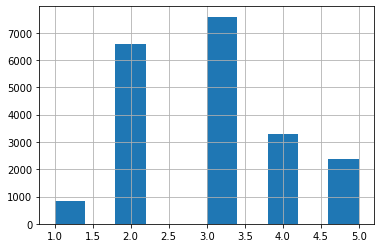

In [16]:
housing["income_cut"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.6, 6., np.inf],  # np.inf positive infinity
                               labels=[1, 2, 3, 4, 5])

housing["income_cut"].hist()

Now you are ready to do stratified sampling based on the income category

In [17]:
# scikit-learn's StratigiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cut"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [18]:
strat_test_set["income_cut"].value_counts() / len(strat_test_set)

3    0.367490
2    0.318798
4    0.159399
5    0.114583
1    0.039729
Name: income_cut, dtype: float64

In [19]:
# now remove the income_cut attribute so that the data is back to its original state:

for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cut", axis = 1, inplace=True)

# Discover and Visualize the Data to Gain Insights

First make sure the test set is put aside and only exploring the training set.

In [20]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

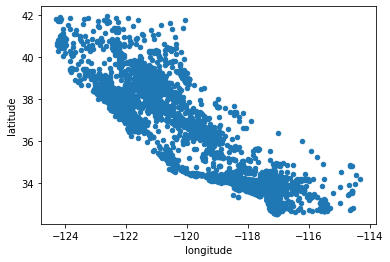

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude")

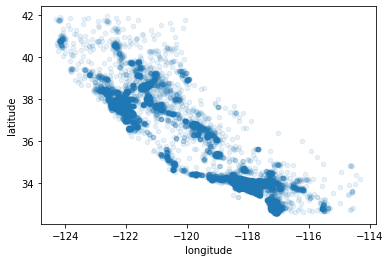

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

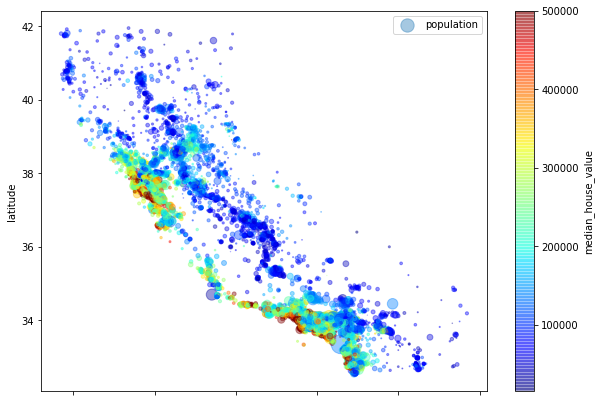

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

## Looking for Correlations

In [24]:
# compute the standard correlation coefficient
corr_matrix=housing.corr()

In [25]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690931
total_rooms           0.131721
housing_median_age    0.109157
households            0.062866
total_bedrooms        0.046003
population           -0.026658
longitude            -0.053456
latitude             -0.136914
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdda7911048>,
      dtype=object)

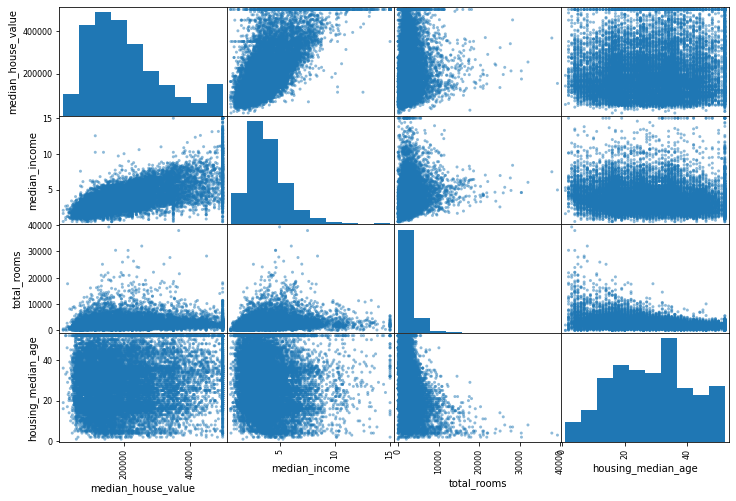

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

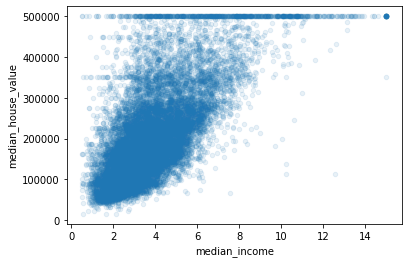

In [27]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In the above plot, we can see the upward trend and the points are not too dispersed. And we can notice that there are visible hrizontal line at $500,000, $450,000 and another around $350,000, perhaps one around $280,000. We need to remove the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

## Experimenting with Attribute Combinations

one last thing you may want to do before preparing the data for Machine Learning algorithms is to try out various attribute combinations.

In [28]:
# The total number of room in a district is not very useful 
# if we don't know how many households there are. 
# Similarly, the total number of bedrooms by itself is not very useful
# we need to compare it to the number of rooms

housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [29]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690931
rooms_per_household         0.146786
total_rooms                 0.131721
housing_median_age          0.109157
households                  0.062866
total_bedrooms              0.046003
population_per_household   -0.022046
population                 -0.026658
longitude                  -0.053456
latitude                   -0.136914
bedrooms_per_room          -0.265794
Name: median_house_value, dtype: float64

bedrooms_per_room attribute is much more correlated with the median house value than the total number of room or bedrooms.<br>
the number of room per household is also more informative than the total number of rooms in a district.<br>

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an iterative process: once we got a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step

# Prepare the Data for Machine Learning Algorithms

In [30]:
# revert to a clean training set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [31]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 20449 to 15661
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16343 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


## Data Cleaning

algorithms connot work with missing features. The total_bedrooms attribute has some missing values. Three options to solve this problem:<br>
  1. Get rid of the corresponding districts.<br>
  2. Get rid of the whole attribute.<br>
  3. Set the values to some value.<br>

In [32]:
housing.dropna(subset=["total_bedrooms"])                 # option 1
housing.drop("total_bedrooms", axis=1)                    # option 2
median = housing["total_bedrooms"].median()               # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

Scikit-Learn provide a handy class to take care of missing values: SimpleImputer.

In [33]:
from sklearn.impute import SimpleImputer

# imputer has simply computed the median of the attribute and stored the results
imputer = SimpleImputer(strategy="median")

In [34]:
housing_num = housing.drop("ocean_proximity", axis=1) # since SimpleImputer can only computed on numerical attributes

imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [35]:
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2124.    ,  433.    , 1167.    ,
        409.    ,    3.5341])

In [36]:
housing_num.median().values

array([-118.5   ,   34.26  ,   29.    , 2124.    ,  433.    , 1167.    ,
        409.    ,    3.5341])

In [37]:
X = imputer.transform(housing_num) 

In [38]:
# X is numpy array than we need to transform it back into pandas dataframe
hoursing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

## Handling Text and Categorical Attribute

In [39]:
housing_cat = housing[["ocean_proximity"]]

In [40]:
housing_cat.head(10)

,ocean_proximity
20449,<1H OCEAN
11274,<1H OCEAN
16581,INLAND
2659,<1H OCEAN
11053,<1H OCEAN
7183,<1H OCEAN
13346,INLAND
9207,INLAND
19422,INLAND
2984,INLAND


convert text to numbers with Scikit-learn's *OrdinalEncoder*

In [41]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)


In [42]:
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [43]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In ML, we prefer the numbers close to each other are more similar than than two distant values.
catogories 0 and 4 are more simiilar than categories 0 and 1.
to sovle this problem we can use onehot encode

In [44]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

In [45]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers



In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True): #no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self # nothing else to do
  def transform(self, X):
    rooms_per_household=X[:,rooms_ix]/X[:,households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room=X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [49]:
housing.shape

(16512, 9)

## Feature Scaling

1. min-max scalling: **sklearn.MinMaxScaler**, tune feature_range to change the range.
2. standardization: **sklearn.StandardScaler**

## Transformation Piplines

There are many data transformation steps that need to be executed in the right order. Scikit-Learn provides Pipline class to help with such sequences of transformations.

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

We used to handled the categorical columns and numerical comlumns separately. In version 0.20, Scikit-Learn introduced the ColumnTransformer

In [51]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [52]:
housing_prepared[:,-5:]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

Note that the OneHotEncoder returns a sparse matrix, while other returns a dense matrix. ColumnTransformer estimates the density of the final matrix (ie. the ratio of nonzeor cells), and it returns a sparse matrix if the density is lower than a given threshold. In this case, density is 0.2 lower than default value 0.3, then it returns a dens matrix.

# Select and Train a Model

## Training and Evaluation on the Trainin Set

### Train a linear regression

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [210545.63580954 243156.44199124 144965.80301413 153440.224189
 224252.90011288]


In [55]:
print("labels: ", list(some_labels))

labels:  [182100.0, 173900.0, 147600.0, 74000.0, 212100.0]


It works, although the predictions are not exactly accurate.
measure this regression model's RMSE on the whole training set using Scikit-Learn's mean_squared_error() function:

In [56]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

68175.5172112703

The most districts' *median_housing_values* range between $120,000 and $265,000, so a typical prediction error of $68,175 is not very satisfying.

This is underfitting problem. The main ways to fix this problem are to select a more powerful model, to feed the training algorithm with better features, or reduce the constraints on the model.

### Train a DecisionTreeRegressor

In [57]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [58]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

0.0

## Better Evaluation Using Cross-Validation

Use the train_test_split() function to split the training set into a smaller training set into smaller training set and a validation set.

### Scikit-Learn's K-fold corss-validation feature

In [59]:
# randomly splits the training set into 10 distinct subsets called folds
# then it trains and evaluates the Decision Tree model 10 times,
# picking a different fold for evaluation every time and training on the other 9 folds.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [60]:
def display_scores(scores):
  print("Scores: ", scores)
  print("Mean: ", scores.mean())
  print("Standard deviation: ", scores.std())

display_scores(tree_rmse_scores)

Scores:  [68320.1156777  70166.9364756  67669.35010738 68866.98700044
 71164.17493361 70187.11094029 71004.96644861 72909.99318614
 71037.37205611 68997.42392278]
Mean:  70032.44307486693
Standard deviation:  1500.154399750347


In [61]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [68998.49548363 65233.23866446 65128.90124108 70546.67540566
 67457.64244344 71523.7626357  72446.5190945  69320.74271623
 67993.19243495 68021.62290798]
Mean:  68667.07930276233
Standard deviation:  2305.6070646879034


### RandomForestRegressor

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_rmse

18323.678866409675

In [63]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [47922.96562189 47809.27137334 47663.87597674 49275.12916375
 48653.87374253 53134.01095608 49027.65749715 50618.91678171
 50263.05037615 49401.31514517]
Mean:  49377.00666345088
Standard deviation:  1568.6069452278564


This is much better. but it is still overfitting.

## Fine-Tune Your Model

### Grid Search
  Using Scikit-Learn's ***GridSearchCV*** to search 

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [65]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [66]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [67]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63414.383318751105 {'max_features': 2, 'n_estimators': 3}
55078.85617683716 {'max_features': 2, 'n_estimators': 10}
52348.54423792797 {'max_features': 2, 'n_estimators': 30}
59221.56533838806 {'max_features': 4, 'n_estimators': 3}
52557.93681956566 {'max_features': 4, 'n_estimators': 10}
50208.39068993535 {'max_features': 4, 'n_estimators': 30}
58773.54355921808 {'max_features': 6, 'n_estimators': 3}
52185.023632120225 {'max_features': 6, 'n_estimators': 10}
49189.1298795087 {'max_features': 6, 'n_estimators': 30}
58070.93731372879 {'max_features': 8, 'n_estimators': 3}
52152.8927250748 {'max_features': 8, 'n_estimators': 10}
49580.12772661216 {'max_features': 8, 'n_estimators': 30}
63118.33916417685 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54048.86951058596 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60015.337234529215 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51448.47484768699 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

## Randomized Search

if there are a lot combinations, it is often preferable to use RandomizedSearchCV instead. Benifits:<br>
  1. we can set whatever the number of iterations as we want. instead of just a few values per hyperparameter with the grid search approach.<br>
  2. we can control over the computing budget you want to allocate to hyperparameter search

## Ensemble Methods

Try to combine the models that perform best. The group (or "ensemble") will often perform better than the best individual model

## Analyze the Best Models and Their Errors



In [68]:
# indicate the relative importance of each attribute for making accurate predictions:
feature_importances = grid_search.best_estimator_.feature_importances_

feature_importances

array([7.48189685e-02, 6.87228039e-02, 4.33847120e-02, 1.72147035e-02,
       1.66053777e-02, 1.70598329e-02, 1.60806971e-02, 3.21415399e-01,
       7.30511949e-02, 1.08469177e-01, 7.37071413e-02, 7.81443452e-03,
       1.53698183e-01, 4.67051724e-05, 3.18397916e-03, 4.72669013e-03])

In [69]:
# display these importance scores next to their corresponding attribute names:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes =num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32141539877162084, 'median_income'),
 (0.15369818349156972, 'INLAND'),
 (0.10846917692519935, 'pop_per_hhold'),
 (0.0748189684688924, 'longitude'),
 (0.07370714131025441, 'bedrooms_per_room'),
 (0.07305119493999769, 'rooms_per_hhold'),
 (0.0687228039356348, 'latitude'),
 (0.043384711979884784, 'housing_median_age'),
 (0.017214703518088886, 'total_rooms'),
 (0.017059832882795837, 'population'),
 (0.01660537769208071, 'total_bedrooms'),
 (0.016080697097188887, 'households'),
 (0.007814434520351583, '<1H OCEAN'),
 (0.004726690130663545, 'NEAR OCEAN'),
 (0.0031839791633442994, 'NEAR BAY'),
 (4.670517243227178e-05, 'ISLAND')]

with this information, we want to try dropping some of the less useful features. for instance, ocean_proximity category

And also we should look at the specific errors that your system makes, then try to understand why ti makes them and what could fix the problem.(adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.)

## Evaluate Your System on the Test Set.

get the predictors and the labels from test set, run full_pipeline to transform the data

In [70]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

50086.23663962084

In [71]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([47933.6520933 , 52150.04504733])

# Launch, Monitor, and Maintain Your system

P80

# Exrcises

## Try SVM regressor

In [72]:
from sklearn.svm import SVR

param_grid =[
             {'kernel': ['linear'], 'C': [10., 30., 60., 100., 300., 1000.0]},
             {'kernel': ['rbf'], 'C': [1.0, 3.0, 30., 100., 300., 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.8s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 54.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 60.0, 100.0, 300.0, 1000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [73]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

69928.17925789923

In [74]:
grid_search.best_params_

{'C': 1000.0, 'kernel': 'linear'}

## Try replacing GridSearchCV with RandomizedSearchCV

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0),
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions = param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)

rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.8s
[CV] C=26290.2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 98.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdd8b061780>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdd8b061908>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [77]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54241.64747459882

In [78]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

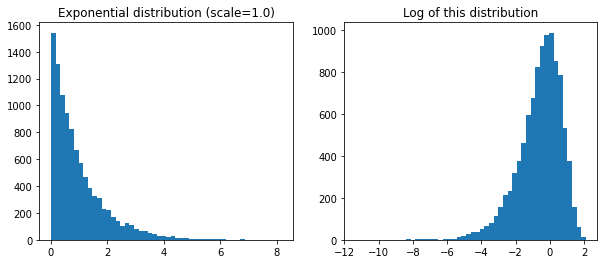

In [79]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

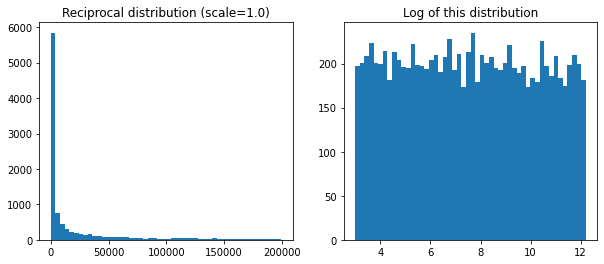

In [80]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

## Try adding a transformer in the preparation pipline to select only the most important attibutes

In [82]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [83]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12])

In [84]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.32141539877162084, 'median_income'),
 (0.15369818349156972, 'INLAND'),
 (0.10846917692519935, 'pop_per_hhold'),
 (0.0748189684688924, 'longitude'),
 (0.07370714131025441, 'bedrooms_per_room')]

In [85]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [86]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [87]:
housing_prepared_top_k_features[0:3]

array([[ 0.34656365,  0.09196914,  0.06693505,  0.23189827,  0.        ],
       [ 0.79098809, -0.4036929 , -0.0749146 ,  0.241693  ,  0.        ],
       [-0.92678727, -0.12691101, -0.01487294,  0.38831736,  1.        ]])

In [88]:

housing_prepared[0:3, top_k_feature_indices]

array([[ 0.34656365,  0.09196914,  0.06693505,  0.23189827,  0.        ],
       [ 0.79098809, -0.4036929 , -0.0749146 ,  0.241693  ,  0.        ],
       [-0.92678727, -0.12691101, -0.01487294,  0.38831736,  1.        ]])

## Try creating a single pipeline that does the full data preparation plus the final prediction

In [89]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [90]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [91]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [199762.88922526 215918.90968584 128580.67322183  85874.65115428]
Labels:		 [182100.0, 173900.0, 147600.0, 74000.0]


## Automatically explore some preparation options using GridSearchCV

In [92]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.5s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.5s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  12.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  13.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 109.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                     

In [93]:
grid_search_prep.best_params_

{'feature_selection__k': 15, 'preparation__num__imputer__strategy': 'mean'}